## Setup

In [1]:
!rm -rf /kaggle/working/*

In [2]:
!git clone https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix

Cloning into 'pytorch-CycleGAN-and-pix2pix'...
remote: Enumerating objects: 2516, done.
remote: Total 2516 (delta 0), reused 0 (delta 0), pack-reused 2516 (from 1)
Receiving objects: 100% (2516/2516), 8.20 MiB | 16.79 MiB/s, done.
Resolving deltas: 100% (1575/1575), done.


In [2]:
import os
os.chdir('pytorch-CycleGAN-and-pix2pix/')

In [4]:
!pip install -r requirements.txt

In [3]:
!pip install dominate

## Preparing dataset

In [5]:
from PIL import Image
import os


def concat_images(path_to_img1, path_to_img2, save_dir, output_img_name):
    image1 = Image.open(path_to_img1)
    image2 = Image.open(path_to_img2)

    if image1.size[1] != image2.size[1]:
        new_height = min(image1.size[1], image2.size[1])
        image1 = image1.resize((int(image1.size[0] * new_height / image1.size[1]), new_height))
        image2 = image2.resize((int(image2.size[0] * new_height / image2.size[1]), new_height))

    combined_image = Image.new("RGB", (image1.width + image2.width, image1.height))

    combined_image.paste(image1, (0, 0))
    combined_image.paste(image2, (image1.width, 0))
    combined_image.save(os.path.join(save_dir, output_img_name))

In [ ]:
import os
import shutil
import random
from sklearn.model_selection import train_test_split
from multiprocessing import Pool


def organize_images(dataset_dir, output_dir, num_images=1000, test_size=0.2):
    original_folder = os.path.join(dataset_dir, 'original')
    retouched_folder = os.path.join(dataset_dir, 'retouched')
    
    original_images = os.listdir(original_folder)
    retouched_images = os.listdir(retouched_folder)

    paired_images = [img for img in original_images if img in retouched_images]

    # shuffle and select defined number of images
    random.shuffle(paired_images)
    selected_images = paired_images[:num_images]

    train_images, test_images = train_test_split(selected_images, test_size=test_size, random_state=42)

    
    # define output subfolders for train and test splits
    for split in ['train', 'test']:
        images_path = os.path.join(output_dir, split)
        os.makedirs(os.path.join(output_dir, split), exist_ok=True)
        
        
    train_args = [concat_images(os.path.join(original_folder, img),
                   os.path.join(retouched_folder, img),
                   os.path.join(output_dir, 'train'),
                   img) for img in train_images]
    
    test_args = [concat_images(os.path.join(original_folder, img),
                  os.path.join(retouched_folder, img),
                  os.path.join(output_dir, 'test'),
                  img) for img in test_images]

In [7]:
organize_images('/kaggle/input/original-and-retouched-faces-images-dataset',
                '/kaggle/working/pytorch-CycleGAN-and-pix2pix/dataset',
                num_images=1000,
                test_size=0.2)

## Load pretrained model


Available models: [edges2shoes, sat2map, map2sat, facades_label2photo, and day2night]

In [4]:
!bash ./scripts/download_pix2pix_model.sh day2night

Note: available models are edges2shoes, sat2map, map2sat, facades_label2photo, and day2night
Specified [day2night]
for details.

--2024-10-26 02:39:57--  http://efrosgans.eecs.berkeley.edu/pix2pix/models-pytorch/day2night.pth
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 217710797 (208M)
Saving to: './checkpoints/day2night_pretrained/latest_net_G.pth'

./checkpoints/day2n 100%[===================>] 207.62M  20.9MB/s    in 14s     

2024-10-26 02:40:12 (14.5 MB/s) - './checkpoints/day2night_pretrained/latest_net_G.pth' saved [217710797/217710797]



## Train model on data

In [1]:
import os

# os.chdir('..')

# os.chdir('pytorch-CycleGAN-and-pix2pix/')

In [7]:
!python train.py --dataroot ./dataset --name face_retouch_v0 --model pix2pix --direction AtoB --display_id -1 --n_epochs 30 --n_epochs_decay 5 --lr 0.00005 --lambda_L1 200 --netG unet_256 --init_type normal # --preprocess None

----------------- Options ---------------
               batch_size: 1                             
                    beta1: 0.5                           
          checkpoints_dir: ./checkpoints                 
           continue_train: False                         
                crop_size: 256                           
                 dataroot: ./dataset                     	[default: None]
             dataset_mode: aligned                       
                direction: AtoB                          
              display_env: main                          
             display_freq: 400                           
               display_id: -1                            	[default: 1]
            display_ncols: 4                             
             display_port: 8097                          
           display_server: http://localhost              
          display_winsize: 256                           
                    epoch: latest                        
 

## Testing

In [8]:
!ls checkpoints/

day2night  day2night_pretrained  face_retouch_v0  night2day


In [9]:
!python test.py --dataroot ./dataset --model pix2pix --name face_retouch_v0  #--preprocess None

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: ./dataset                     	[default: None]
             dataset_mode: aligned                       
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                         	[default: None]
                load_iter: 0                            

## Visualizing

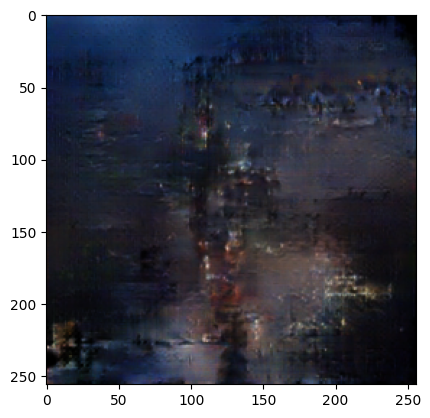

In [10]:
import matplotlib.pyplot as plt

img = plt.imread('./results/day2night_pretrained/test_latest/images/02014_fake_B.png')
plt.imshow(img)

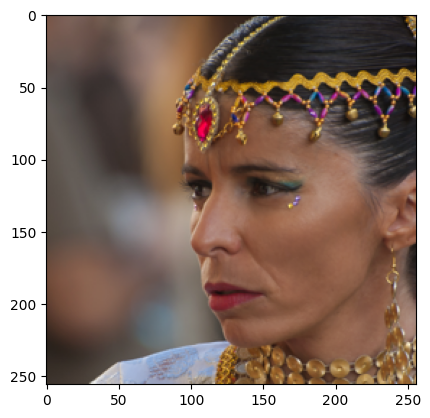

In [11]:
import matplotlib.pyplot as plt

img = plt.imread('./results/day2night_pretrained/test_latest/images/02014_real_B.png')
plt.imshow(img)